# Predicting NaNoWriMo winners with Logistic Regression

As the variable I want to predict is binary (1 if a writer is a winner, 0 if otherwise) I decided to use a logistic regression as my prediction model.  

In [2]:
# import the data
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

writers = pd.read_csv("../clean data/user_summary_no2015.csv", index_col=0)
writers.head()

,Writer Name,Member Length,LifetimeWordCount,url,Age,Birthday,Favorite books or authors,Favorite noveling music,Hobbies,Location,...,Expected Max Submission,Expected Max Day,Expected Std Submissions,Expected Consec Subs,FW Total,FW Sub,FH Total,FH Sub,SH Total,SH Sub
0,Nicaless,2,50919,http://nanowrimo.org/participants/nicaless,24,December 20,"Ursula Le Guin, J.K.","Classical, Musicals","Reading, Video Games, Blogging, Learning","San Francisco, CA",...,24935.0,28.000000,6235.712933,12.000000,6689,6,12486,9,11743,3
1,Rachel B. Moore,10,478090,http://nanowrimo.org/participants/rachel-b-moore,NaN,NaN,"2666, Unaccustomed Earth, Exit Music, Crazy Lo...","Belle and Sebastian, Elliott Smith, PJ Harvey,...","Reading, volunteering, knitting, listening to ...",San Francisco,...,3809.0,9.000000,1002.295167,6.800000,16722,7,24086,14,26517,14
2,abookishbabe,1,0,http://nanowrimo.org/participants/abookishbabe,NaN,April 2,"Colleen Hoover, Veronica Roth, Jennifer Niven,...",Tori Kelley,"Reading (DUH), Day dreaming, Going to Disneyla...","Sacramento, CA",...,NaN,NaN,NaN,NaN,28632,1,29299,2,0,0
3,alexabexis,11,475500,http://nanowrimo.org/participants/alexabexis,NaN,NaN,NaN,Three Goddesses playlist Florence + the Machin...,"drawing, reading, movies & TV shows, comics, p...",New York City,...,2325.0,8.545455,570.626795,8.090909,25360,7,38034,12,40766,9
4,AllYellowFlowers,3,30428,http://nanowrimo.org/participants/AllYellowFlo...,NaN,NaN,"Lolita, Jesus' Son, Ask the",the sound of the coffeemaker,cryptozoology,Allston,...,2054.5,4.500000,538.273315,21.000000,1800,5,5300,10,5700,9


In [3]:
writers.columns

Index([u'Writer Name', u'Member Length', u'LifetimeWordCount', u'url', u'Age',
       u'Birthday', u'Favorite books or authors', u'Favorite noveling music',
       u'Hobbies', u'Location', u'Occupation', u'Primary Role',
       u'Sponsorship URL', u'Expected Final Word Count',
       u'Expected Daily Average', u'CURRENT WINNER', u'Current Donor', u'Wins',
       u'Donations', u'Participated', u'Consecutive Donor',
       u'Consecutive Wins', u'Consecutive Part', u'Part Years', u'Win Years',
       u'Donor Years', u'Num Novels', u'Expected Num Submissions',
       u'Expected Avg Submission', u'Expected Min Submission',
       u'Expected Min Day', u'Expected Max Submission', u'Expected Max Day',
       u'Expected Std Submissions', u'Expected Consec Subs', u'FW Total',
       u'FW Sub', u'FH Total', u'FH Sub', u'SH Total', u'SH Sub'],
      dtype='object')

In [4]:
# convert primary role and sponsorship url to binary vars
writers['Primary Role'][writers['Primary Role'] == 'Municipal Liaison'] = 1
writers['Primary Role'][writers['Primary Role'] != 1] = 0

writers['Sponsorship URL'].fillna(0, inplace=True)
writers['Sponsorship URL'][writers['Sponsorship URL'] != 0] = 1

In [5]:
# let's keep ALL NUMERIAL COLUMNS except the CURRENT WINNER column which we will use as response
features = writers._get_numeric_data()

In [6]:
del features['CURRENT WINNER']
features.head()

,Member Length,LifetimeWordCount,Age,Expected Final Word Count,Expected Daily Average,Current Donor,Wins,Donations,Participated,Consecutive Donor,...,Expected Max Submission,Expected Max Day,Expected Std Submissions,Expected Consec Subs,FW Total,FW Sub,FH Total,FH Sub,SH Total,SH Sub
0,2,50919,24,50919.000000,1697.300000,0,1,1,1,1,...,24935.0,28.000000,6235.712933,12.000000,6689,6,12486,9,11743,3
1,10,478090,NaN,47809.000000,1593.633333,1,8,8,10,8,...,3809.0,9.000000,1002.295167,6.800000,16722,7,24086,14,26517,14
2,1,0,NaN,NaN,NaN,1,0,0,0,0,...,NaN,NaN,NaN,NaN,28632,1,29299,2,0,0
3,11,475500,NaN,43227.272727,1440.909091,1,7,7,11,4,...,2325.0,8.545455,570.626795,8.090909,25360,7,38034,12,40766,9
4,3,30428,NaN,15214.000000,507.133333,0,0,0,2,0,...,2054.5,4.500000,538.273315,21.000000,1800,5,5300,10,5700,9


In [7]:
y = writers['CURRENT WINNER'].values

In [8]:
# inputting 0 for users without prior data for daily avg, avg submission, num submissions etc. and so are marked NaN
features.fillna(0, inplace=True)
features.describe()

,Member Length,LifetimeWordCount,Age,Expected Final Word Count,Expected Daily Average,Current Donor,Wins,Donations,Participated,Consecutive Donor,...,Expected Max Submission,Expected Max Day,Expected Std Submissions,Expected Consec Subs,FW Total,FW Sub,FH Total,FH Sub,SH Total,SH Sub
count,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,...,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000
mean,4.212575,172552.676647,8.596806,36428.312194,1214.277073,0.317365,2.606786,1.421158,3.656687,1.047904,...,4764.389341,10.005534,1314.411102,9.573348,12203.137725,4.413174,20962.403194,8.137725,17100.556886,6.520958
std,3.255209,329113.331830,14.463648,43782.218313,1459.407277,0.465916,4.651782,3.044384,4.899582,1.760029,...,5727.358954,8.406292,2011.241171,8.393503,39000.987493,2.614373,54462.877403,5.140330,21562.099582,6.259238
min,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,9818.000000,0.000000,7443.250000,248.108333,0.000000,0.000000,0.000000,1.000000,0.000000,...,955.000000,1.000000,256.685927,0.000000,2258.000000,2.000000,3925.000000,3.000000,0.000000,0.000000
50%,4.000000,93385.000000,0.000000,37594.333333,1253.144444,0.000000,1.000000,0.000000,2.000000,0.000000,...,3546.500000,9.333333,873.018486,8.500000,7890.000000,5.000000,15212.000000,10.000000,10900.000000,5.000000
75%,6.000000,206482.000000,20.000000,50734.200000,1691.140000,1.000000,3.000000,2.000000,5.000000,1.000000,...,6250.000000,16.200000,1516.145753,16.000000,12361.000000,7.000000,23832.000000,13.000000,28005.000000,13.000000
max,13.000000,4562712.000000,61.000000,651816.000000,21727.200000,1.000000,52.000000,36.000000,52.000000,9.000000,...,51238.000000,30.000000,23874.872328,30.000000,630036.000000,7.000000,1000000.000000,14.000000,210000.000000,16.000000


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report

### Normalize data

In [10]:
scaler = StandardScaler()
features_norm = scaler.fit_transform(features)
features_norm[1]

array([ 1.77967343,  0.92929298, -0.5949674 ,  0.26019839,  0.26019839,
        1.46660949,  1.16054543,  2.1631367 ,  1.29595831,  3.95393831,
        1.98638802,  2.35830378,  1.92083955, -0.29678396, -0.38505565,
       -0.01942619,  0.25599572, -0.16697823, -0.11973645, -0.15534084,
       -0.33074635,  0.11598114,  0.99045236,  0.05741009,  1.14158714,
        0.43714921,  1.19607487])

### Apply Logistic Regression

In [11]:
X_train, X_test, y_train, y_test = train_test_split(features_norm,y, test_size=0.2, random_state=0)

In [12]:
model_lr = LogisticRegression(C=5)
cross_val_score(model_lr,X_train, y_train,cv=10).mean()

0.97749374609130713

And wow! That's a very good cross validation score! Now let's check out the model's coefficient and precision/recall scores.



In [13]:
model_lr = LogisticRegression(C=5).fit(X_train, y_train)
coefficients=model_lr.coef_.ravel()
coefficients

array([ 0.02520523,  0.62688091, -0.47607049, -0.40851403, -0.40851403,
        0.13470812,  0.41434166, -1.02103822,  0.17685377,  0.76671752,
        0.0906466 ,  0.24629328,  0.31249113,  0.10064005,  0.28534595,
       -1.21116754,  0.18072087,  0.34617884, -0.53207593,  0.40693384,
       -0.24553556,  4.61721888, -0.30091101,  5.68824533,  1.53174036,
        5.81078965,  0.55780255])

In [14]:
print classification_report(y_test,model_lr.predict(X_test))
print model_lr.score(X_test,y_test)

             precision    recall  f1-score   support

          0       1.00      0.93      0.96        55
          1       0.92      1.00      0.96        46

avg / total       0.96      0.96      0.96       101

0.960396039604


### Visualize the results of the Logistic Regression

In [15]:
from matplotlib.colors import ListedColormap
%matplotlib inline

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [32]:
features_pca = pca.fit(features_norm).transform(features_norm)
pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(features_pca,y, test_size=0.2, random_state=0)
preds = LogisticRegression(C=5).fit(pca_X_train, pca_y_train).predict(pca_X_test)

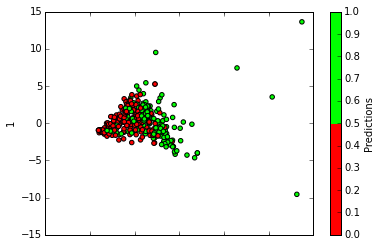

In [36]:
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
df1 = pd.DataFrame(pca_X_train)
df1['Predictions'] = pca_y_train
df1.plot(kind='scatter', x=0, y=1, c='Predictions', colormap = cmap_bold)

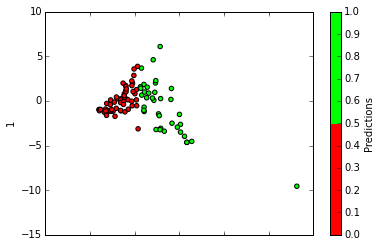

In [37]:
df2 = pd.DataFrame(pca_X_test)
df2['Predictions'] = preds
df2.plot(kind='scatter', x=0, y=1, c='Predictions', colormap = cmap_bold)

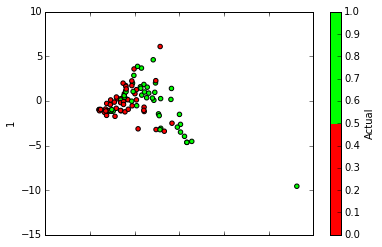

In [39]:
df2 = pd.DataFrame(pca_X_test)
df2['Actual'] = pca_y_test
df2.plot(kind='scatter', x=0, y=1, c='Actual', colormap = cmap_bold)

Now let's use a Decision Tree to classify, and see what features are most predictive with a Decision Tree

In [52]:
from sklearn.tree import DecisionTreeClassifier

In [53]:
model_dt = DecisionTreeClassifier(max_depth=4)
print cross_val_score(model_dt, X_train, y_train, cv=10).mean()

model_dt.fit(X_train, y_train)
print classification_report(y_test,model_dt.predict(X_test))
print model_dt.score(X_test, y_test)

0.969676360225
             precision    recall  f1-score   support

          0       0.98      0.91      0.94        55
          1       0.90      0.98      0.94        46

avg / total       0.94      0.94      0.94       101

0.940594059406


In [54]:
dt_importances = pd.DataFrame(zip(features.columns, model_dt.feature_importances_))
dt_importances.sort_values(1, ascending=False).head() # most to least predictive of being 0 ??? because negative? 

,0,1
25,SH Total,0.799393
23,FH Total,0.185607
18,Expected Max Day,0.010158
4,Expected Daily Average,0.004842
0,Member Length,0.000000


SH Total, and FH Total are metrics collected after the current contest has started.  Let's build a model now with just information we have from past contests and see how that works.  